# LeNet 5



In [1]:
from algorithms import *
from lenet5 import *
import numpy as np
import matplotlib.pyplot as plt

_, (test_x, test_y) = load_MNIST()

path = './data/lenet5'

lenet5 = LeNet5(path=path, load=True)

epsilon = 0.25
d = 28*28

lab = lenet5.predict(test_x)
indexes = lab == test_y
data = test_x[indexes]
labels = test_y[indexes]

print(len(labels))  # 9826

# M = num workers; we consider a number of workers <=10
M = 10
data_per_classes = []
for label_class in range(0, 10):
    data_per_classes.append(data[labels == label_class][:100])

data_per_classes = np.array(data_per_classes)
data_workers = []

for offset in range(0, 100, M):
    image_worker = []
    for c in range(0, 10):
        image_worker.extend(data_per_classes[c, offset:offset+M, :, :, :])
    data_workers.append(image_worker)

data_workers = np.array(data_workers)
print(data_workers.shape)  # now all 10 workers have 100 images, 10 for each class.

y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.repeat(y, 10)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
9826
(10, 100, 28, 28, 1)


# Universal Adversarial Attacks

In [2]:
def plot_perturbation(perturbation, m):
  fig, ax = plt.subplots(figsize=(12, 12))
  img = plt.imshow(perturbation.reshape((28, 28)))
  fig.colorbar(img, ax=ax, fraction=0.03, pad=0.05)
  plt.savefig(f"./perturbation_{m}", bbox_inches="tight")
  plt.show()

def plot_perturbated_img(perturbation, m):
  image = test_x[5].numpy().reshape(28,28)
  img_noise = image + perturbation.reshape((28, 28))
  fig, ax = plt.subplots(1, 2,figsize=(5, 5))
  a = ax[0].imshow(image, cmap='Greys')
  b = ax[1].imshow(img_noise, cmap='Greys')
  fig.colorbar(a, ax=ax[0], fraction=0.03, pad=0.05)
  fig.colorbar(b, ax=ax[1], fraction=0.03, pad=0.05)
  plt.savefig(f"./image_perturbation_example_{m}", bbox_inches="tight")
  plt.show()

def plot_loss(loss_history, m):
  plt.figure(figsize=(10,6))
  plt.plot(m, loss_history[:, 0])
  plt.title('loss')

def plot_accuracy(loss_history, m):
  plt.figure(figsize=(10,6))
  plt.plot(m, loss_history[:, 1])
  plt.title('accuracy')

## Decentralized Stochastic Gradient Free FW

In [6]:
T = 20

loss_history = []

for m in range(5, 40, 5):
  print ("m = ", m)
  delta = decentralized_stochastic_gradient_free_FW(data_workers, y, lenet5.negative_loss, m, T, M, epsilon, d)
  np.save(f"./data/perturbation_{m}", delta[-1])

  plot_perturbation(delta[-1], m)
  plot_perturbated_img(delta[-1], m)

  perturbation = np.tile(delta[-1], data.shape[0])
  perturbation = perturbation.reshape((data.shape[0],28,28,1))
  perturbated_data = data + perturbation
  perturbated_data = np.clip(perturbated_data, 0., 1.)

  loss = lenet5.model.evaluate(perturbated_data, labels)
  loss_history.append(loss)


m =  5
Iteration number  1


KeyboardInterrupt: 

In [ ]:
m=40
delta = decentralized_stochastic_gradient_free_FW(data_workers, y, lenet5.negative_loss, m, T, M, epsilon, d)
np.save(f"./data/perturbation_{m}", delta[-1])

plot_perturbation(delta[-1], m)
plot_perturbated_img(delta[-1], m)

perturbation = np.tile(delta[-1], data.shape[0])
perturbation = perturbation.reshape((data.shape[0],28,28,1))
perturbated_data = data + perturbation
perturbated_data = np.clip(perturbated_data, 0., 1.)

loss = lenet5.model.evaluate(perturbated_data, labels)
loss_history.append(loss)

Iteration number  1
Iteration number  2


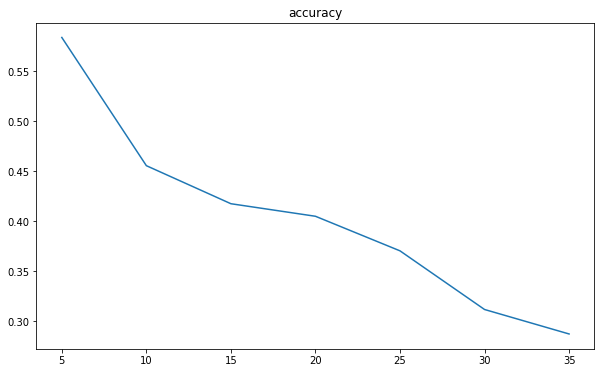

In [23]:
history = np.array(loss_history)
m = [5, 10, 15, 20, 25, 30, 35]

plot_accuracy(history, m)

# Tests

In [7]:
m=35
#np.save(f"./data/perturbation_{m}", delta[-1])
delta = np.load(f"./perturbations/perturbation_{m}.npy")
delta.shape

(784,)

In [10]:
image = test_x[5].numpy().reshape(28,28)
img_noise = image + delta.reshape((28, 28))
print(lenet5.predict(np.array([img_noise.reshape(28, 28 ,1)])))

[3]


In [ ]:
image = test_x[5].numpy().reshape(28,28)
delta_mean = np.mean(delta, axis=0)
img_noise = image + delta_mean.reshape((28, 28))
fig, ax = plt.subplots(1, 2,figsize=(5, 5))
ax[0].imshow(image, cmap='Greys')
ax[1].imshow(img_noise, cmap='Greys')
plt.savefig(f"./image_perturbation_example_{m}", bbox_inches="tight")
plt.show()
print(lenet5.predict(np.array([img_noise.reshape(28, 28 ,1)])))

In [22]:
perturbation = np.tile(delta[-1], data.shape[0])
perturbation = perturbation.reshape((data.shape[0],28,28,1))
perturbated_data = data + perturbation
perturbated_data = np.clip(perturbated_data, 0., 1.)

In [23]:
lenet5.model.evaluate(perturbated_data, labels)

307/307 [==============================] - 3s 10ms/step - loss: 2.3129 - accuracy: 0.6238


[2.312938928604126, 0.6237623691558838]

In [16]:
lenet5.model.evaluate(data, labels)

307/307 [==============================] - 3s 10ms/step - loss: 0.0113 - accuracy: 1.0000


[0.011310586705803871, 1.0]

In [30]:
# Gaussian noise
gaussian_noise_data = data + np.random.normal(0, 0.3, data.shape)
gaussian_noise_data = np.clip(gaussian_noise_data, 0., 1.)
lenet5.model.evaluate(gaussian_noise_data, labels)

307/307 [==============================] - 3s 10ms/step - loss: 1.0043 - accuracy: 0.8067


[1.004286766052246, 0.8066754937171936]

In [25]:
gaussian_noise_data.shape

(9797, 28, 28, 1)

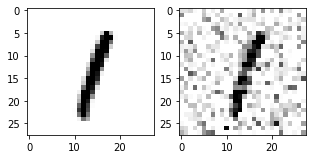

In [31]:
gaussian_noise = np.random.normal(0, 0.3, (28,28))
fig, ax = plt.subplots(1, 2,figsize=(5, 5))
ax[0].imshow(image, cmap='Greys')
ax[1].imshow(np.clip(image+gaussian_noise, 0.,1.), cmap='Greys')
plt.savefig(f"./gaussian_noise_{m}", bbox_inches="tight")
plt.show()


# Decentralized Variance-Reduced Zeroth-Order FW

In [3]:
images = data[:1000]
targets = labels[:1000]
n = 5
S2 = 3
q = 5
S1 = len(images)
M = 10
T = 10
epsilon = 0.25
d = 784

In [4]:
delta = decentralized_variance_reduced_zo_FW(images, targets, lenet5.negative_loss, S2, T, M, n, epsilon, d, q, S1)
np.save(f"./data/perturbation_variance", delta[-1])

perturbation = np.tile(delta[-1], data.shape[0])
perturbation = perturbation.reshape((data.shape[0],28,28,1))
perturbated_data = data + perturbation
perturbated_data = np.clip(perturbated_data, 0., 1.)

loss = lenet5.model.evaluate(perturbated_data, labels)
loss_history.append(loss)

Iteration number  1
1/1 [==============================] - 0s 2ms/step - loss: 9.4755e-04 - accuracy: 1.0000


ValueError: cannot reshape array of size 313600 into shape (20,28,28,1)